# Demonstration of the BuTools fitting package

Set the precision and import the necessary packages

In [1]:
%precision %g
%run "~/github/butools/Python/BuToolsInit.py"

Butools V2.0
Packages loaded: utils, mc, moments, reptrans, trace, ph, dph, map, dmap, fitting, mam, queues
Global variables: 
butools.verbose = False , butools.checkInput = True , butools.checkPrecision = 1e-12


First the global butools.verbose flag is set to True to obtain more messages from the functions.

In [2]:
butools.verbose = True

## Phase-type distribution fitting

First we load a trace (BC-pAug89), calculate the pdf, the cdf, and the first 5 moments. To obtain the empirical pdf, we need to specify the interval boundaries as well. PdfFromTrace returns the relative number of samples falling into the boundaries divided by the interval sizes.

In [3]:
tr = np.loadtxt("../test/data/bctrace.iat")
intBounds = np.linspace(0, 0.2, 250)
(xt,yt) = PdfFromTrace (tr, intBounds)
(cxtFull,cytFull) = CdfFromTrace (tr)
momt = MarginalMomentsFromTrace (tr, 5)

The first algorithm to test is G-Fit, that obtains a hyper-Erlang distribution by the EM algorithm. It has many parameters, but fortunately it can be used in a very user-friendly way just specifying the number of phases of the result.

In [4]:
alpha, A, logli = PHFromTrace(tr, 5)
print("alpha=",alpha)
print("A=",A)

EM algorithm terminated. [1, 1, 1, 1, 1]
Num of iterations:  27 , logli:  4.85108360418
alpha= [[ 0.06502731  0.85788487  0.          0.07708782  0.        ]]
A= [[   -63.30763115      0.              0.              0.              0.        ]
 [     0.           -815.71806894    815.71806894      0.              0.        ]
 [     0.              0.           -815.71806894      0.              0.        ]
 [     0.              0.              0.         -12563.08792279
   12563.08792279]
 [     0.              0.              0.              0.         -12563.08792279]]


The density functions of the result and of the trace are compared below. Note that we did not use *PdfFromPH*, but *IntervalPdfFromPH* instead, which is more appropriate to compare with an empirical density. *IntervalPdfFromPH* takes interval boundaries, and returns the probabilities that the PH distributed random variable falls into these intervals divided by the interval lengths.

In [5]:
(xg,yg) = IntervalPdfFromPH (alpha, A, intBounds)

(0.001, 0.2)

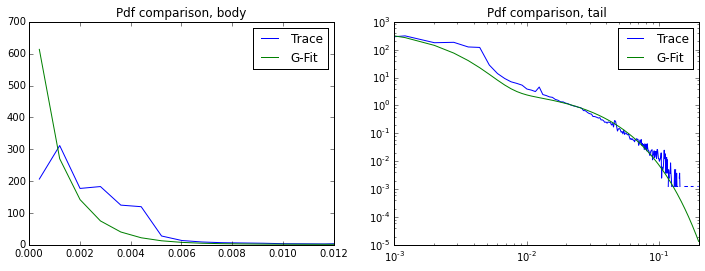

In [6]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.title("Pdf comparison, body")
plt.plot(xt,yt,label="Trace")
plt.plot(xg,yg,label="G-Fit")
plt.xlim(0,0.012)
plt.legend(loc='best')
plt.subplot(122)
plt.title("Pdf comparison, tail")
plt.loglog(xt,yt,label="Trace")
plt.loglog(xg,yg,label="G-Fit")
plt.legend(loc='best')
plt.xlim(1e-3,2e-1)

The evolution of the result of the GFIT algorithm can be demonstrated with the following fancy animation.

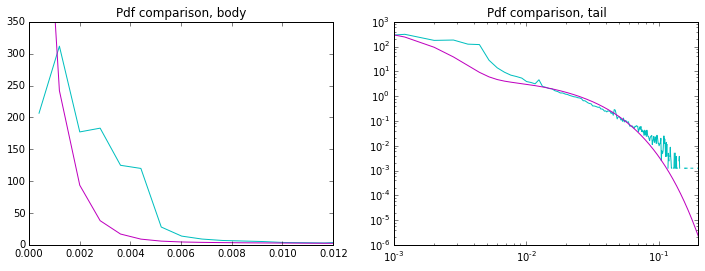

In [7]:
from IPython.display import clear_output, display
butools.verbose = False

fig = plt.figure(figsize=(12,4))
pl1 = fig.add_subplot(121)
plt.title("Pdf comparison, body")
plt.xlim(0,0.012)
plt.ylim(0,350)
plt.legend(loc='best')
pl2 = fig.add_subplot(122)
plt.title("Pdf comparison, tail")
plt.xlim(1e-3,2e-1)
plt.ylim(1e-6,1e3)
plt.legend(loc='best')

# first we let gfit generate an initial guess and return it in a vector-vector format
pi, lambd, logli = PHFromTrace (tr, [1,2,3], maxIter=0, result="vecvec")
# the following loop executes 5 EM steps in each iteration
for i in range(20):
    # execute 5 EM steps
    pi, lambd, logli = PHFromTrace (tr, [1,2,3], maxIter=5, initial=(pi, lambd), result="vecvec")
    # obtain the PH representation
    alpha, A, logli = PHFromTrace (tr, [1,2,3], maxIter=0, initial=(pi, lambd))
    (xg,yg) = IntervalPdfFromPH (alpha, A, intBounds)   
    if i>0:
        clear_output()
        pl1.lines.pop(0)
        pl1.lines.pop(0)
        pl2.lines.pop(0)
        pl2.lines.pop(0)
    pl1.plot(xt,yt,label="Trace")
    pl1.plot(xg,yg,label="G-Fit")
    pl2.loglog(xt,yt,label="Trace")
    pl2.loglog(xg,yg,label="G-Fit")
    display(fig)
clear_output()

There are other ways to quantify the success of the fitting method as well, like 

* comparing the moments
* calculating the squared difference of the pdf or of the ccdf
* calculating the relative entropy of the pdf

Let us start with the comparison of the moments

In [8]:
momg = MomentsFromPH (alpha, A, 5)
print("Moments of the trace: ", momt)
print("Moments of the PH: ", momg)

Moments of the trace:  [0.0031428217360000002, 4.1717980021152e-05, 2.0104235218006803e-06, 1.8171548170691348e-07, 2.5288141295642176e-08]
Moments of the PH:  [0.0031428217359989125, 3.710428451823741e-05, 1.2614052764100586e-06, 6.6526754027202468e-08, 4.4628365202736856e-09]


We also have a function to obtain the squared difference of the empirical pdfs.

In [9]:
print("Squared difference of the pdfs: ", EmpiricalSquaredDifference (yt, yg, intBounds))

Squared difference of the pdfs:  0.24082034206


Obtaining the squared difference of the cdfs is a bit more involved. The empirical cdf is too large, thus we take only every 1000th item of it. Furthermore, we do not have the interval bounds in this case. The "x" values can serve as interval bounds, but in this case the last "y" has to be dropped out (as the number of interval bounds needs to be larger than the number of values by one)

In [10]:
cxt = cxtFull[::1000]
cyt = cytFull[::1000]
cyg = CdfFromPH (alpha, A, cxt)
print("Squared difference of the pdfs: ", EmpiricalSquaredDifference (cyt[:-1], cyg[:-1], cxt))

Squared difference of the pdfs:  3.0208745972e-10


The relative entropy of the two pdfs is

In [11]:
print("Relative entropy: ", EmpiricalRelativeEntropy(yt, yg, intBounds))

Relative entropy:  1.12254464426


The likelihood of the trace is

In [12]:
LikelihoodFromTrace(tr,alpha,A)

4.91743

## Fitting of Markovian Arrival Processes

MAPFromTrace is similar to PHFromTrace, but it returns a MAP instead of a PH. Unfortunately it is much slower, thus we need to obtain a smaller trace for the experiments. The C++ implementation of the procedure (SPEMFIT, https://bitbucket.org/ghorvath78/spemfit) is much faster and is able to operate on millions of measurements with a reasonable speed.

In [13]:
trSmall = tr[0:10000]

In [14]:
D0, D1, logli = MAPFromTrace(trSmall, 5)

The *LikleihoodFromTrace* works with MAPs as well, not only with PHs.

In [15]:
LikelihoodFromTrace(trSmall, D0, D1)

5.12396

To evaluate the accuracy of the obtained MAP, the autocorrelation functions are compared.

In [16]:
trAcf = LagCorrelationsFromTrace(tr, 10)
print("trAcf=", trAcf)
mapAcf = LagCorrelationsFromMAP(D0, D1, 10)
print("mapAcf=",mapAcf)

trAcf= [0.20004885484210852, 0.18927480124417365, 0.13895117398714094, 0.14213400151438738, 0.11712720506721902, 0.12367824446146115, 0.1121211150989561, 0.10051068930807179, 0.10019070967277495, 0.098797210298893726]
mapAcf= [ 0.24889205  0.17665283  0.12882047  0.09638293  0.07380231  0.05764988
  0.04578178  0.03684042  0.02995226  0.02454429]


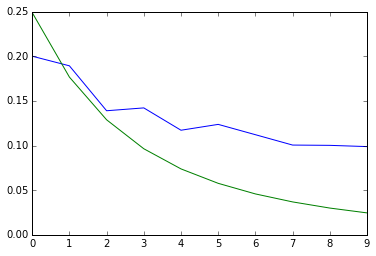

In [17]:
plt.plot(np.array([trAcf,mapAcf]).T);

The squared difference and the relative entropy of the autocorrelation functions:

In [18]:
sqAcf = SquaredDifference(mapAcf, trAcf)
reAcf = RelativeEntropy(mapAcf, trAcf)
print("sqAcf=",sqAcf)
print("reAcf=",reAcf)

sqAcf= 0.0298793020124
reAcf= 0.340174607035
